## Illustrate Explainability with Predictive Densities
Author: Clara Hoffmann \
Overview:
1. Load packages and data
2. Compute predictive densities
3. Plot predictive densities
4. Plot images

In [1]:
# load packages
import cv2
import imageio
import pandas as pd
import numpy as np
import tensorflow as tf
from helpers_trans import DensityPredictor, build_model_mc_dropout, build_model_mdn
import matplotlib.pyplot as plt
from tqdm import tqdm
import statsmodels.api as sm
from mdn import sample_from_output

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.4) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [47]:
# load density
density_path = '../../../data/commaai/density/gaussian_density_filtered.csv'
density = pd.read_csv(density_path)

In [3]:
path_all_imgs = '../../../data/commaai/training_files_filtered/indices/train_indices.csv'
all_img_df = pd.read_csv(path_all_imgs)
img_path_base = '../../../data/commaai/train_bags_2/'
paths = img_path_base + all_img_df['path'][0:5]

In [4]:
path_all_imgs = '../../../data/commaai/training_files_filtered/indices/review.csv'
review_df_test = pd.read_csv(path_all_imgs)

In [5]:
# paths of images that interest us
paths = ['../../../data/commaai/train_bags_2/0/80_436run1.png', # parting road, closer
         '../../../data/commaai/train_bags_2/0/121_254run1.png',# # parting road, closer, other side
        '../../../data/commaai/train_bags_2/0/118_977run1.png', # left turn only half visible
        ]

## 2. Compute predictive densities

In [6]:
# predictive densities ridge prior + va
predictor_va_prec = DensityPredictor('va_ridge', 'precise', 10)
predictor_va_prec.load_bzeta_model()
predictor_va_prec.predict_Bzeta(paths, True, False)
predictor_va_prec.choose_method('va_ridge')
predictor_va_prec.initialize_grid(density, 65536)
densities_va_prec = predictor_va_prec.predict_density()

building model ...
loading model weights ...
... finished loading weights.
start predicting Bzeta on images ...
... finished predicting Bzeta on images.
chose variational approximation with ridge prior as method
computing fixed values for density estimation ...
...finished computing fixed values.


In [7]:
# predictive densities ridge prior + va
predictor_va_prec_im = DensityPredictor('va_ridge', 'imprecise', 10)
predictor_va_prec_im.load_bzeta_model()
predictor_va_prec_im.predict_Bzeta(paths, True, False)
predictor_va_prec_im.choose_method('va_ridge')
predictor_va_prec_im.initialize_grid(density, 65536)
densities_va_prec_im = predictor_va_prec_im.predict_density()

building model ...
loading model weights ...
... finished loading weights.
start predicting Bzeta on images ...
... finished predicting Bzeta on images.
chose variational approximation with ridge prior as method
computing fixed values for density estimation ...
...finished computing fixed values.


In [8]:
# predictive densities horseshoe prior + hmc
#predictor_hmc_prec_horse = DensityPredictor('hmc_horseshoe', 'precise', 10)
#predictor_hmc_prec_horse.load_bzeta_model()
#predictor_hmc_prec_horse.predict_Bzeta(paths, True, False)
#predictor_hmc_prec_horse.choose_method('hmc_horseshoe')
#predictor_hmc_prec_horse.initialize_grid(density, 65536)
#densities_hmc_prec_horse = predictor_hmc_prec_horse.predict_density()

In [9]:
# predictive densities horseshoe prior + va
predictor_va_prec_horse = DensityPredictor('va_horseshoe', 'precise', 10)
predictor_va_prec_horse.load_bzeta_model()
predictor_va_prec_horse.predict_Bzeta(paths, True, False)
predictor_va_prec_horse.choose_method('va_horseshoe')
predictor_va_prec_horse.initialize_grid(density, 65536)
densities_va_prec_horse = predictor_va_prec_horse.predict_density()

building model ...
loading model weights ...
... finished loading weights.
start predicting Bzeta on images ...
... finished predicting Bzeta on images.
chose variational approximation with horseshoe prior as method
computing fixed values for density estimation ...
...finished computing fixed values.


In [10]:
# predictive densities horseshoe prior + va
predictor_va_prec_horse_im = DensityPredictor('va_horseshoe', 'imprecise', 10)
predictor_va_prec_horse_im.load_bzeta_model()
predictor_va_prec_horse_im.predict_Bzeta(paths, True, False)
predictor_va_prec_horse_im.choose_method('va_horseshoe')
predictor_va_prec_horse_im.initialize_grid(density, 65536)
densities_va_prec_horse_im = predictor_va_prec_horse_im.predict_density()

building model ...
loading model weights ...
... finished loading weights.
start predicting Bzeta on images ...
... finished predicting Bzeta on images.
chose variational approximation with horseshoe prior as method
computing fixed values for density estimation ...
...finished computing fixed values.


In [11]:
# predictive densities ridge prior + hmc
#predictor_hmc_prec = DensityPredictor('hmc_ridge', 'precise', 10)
#predictor_hmc_prec.load_bzeta_model()
#predictor_hmc_prec.predict_Bzeta(paths, True, False)
#predictor_hmc_prec.choose_method('hmc_ridge')
#predictor_hmc_prec.initialize_grid(density, 65536)
#densities_hmc_prec = predictor_hmc_prec.predict_density()

## Compute predictive densities MC-dropout

In [12]:
checkpoint_path = '../../../data/models/mc_dropout_cpl/export/'
model = build_model_mc_dropout()
model.load_weights(tf.train.latest_checkpoint(checkpoint_path))

In [13]:
mc_samples = 1000
preds = []
for i in tqdm(range(0, len(paths))):
    img = (imageio.imread(str(paths[i]))[:,:,0:3]/255).reshape(1,66,200,3)
    x_pred = np.repeat(img, mc_samples, axis = 0)
    pred = model.predict(x_pred.reshape(-1,66,200,3))
    preds.append(pred)
preds = np.array(preds)

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [02:33<00:00, 51.26s/it]


In [14]:
densities = []
supports = []
for i in tqdm(range(0, len(paths))):
    kde = sm.nonparametric.KDEUnivariate(preds[i,:,:])
    kde.fit() # Estimate the densities
    support = kde.support
    endog = kde.endog
    density = kde.density
    supports.append(support)
    densities.append(density) 

100%|██████████| 3/3 [00:00<00:00, 206.62it/s]


In [15]:
checkpoint_path = '../../../data/models/mc_dropout_cil/export/'
model = build_model_mc_dropout()
model.load_weights(tf.train.latest_checkpoint(checkpoint_path))

In [16]:
mc_samples = 1000
preds_im = []
for i in tqdm(range(0, len(paths))):
    img = (imageio.imread(str(paths[i]))[:,:,0:3]/255).reshape(1,66,200,3)
    x_pred = np.repeat(img, mc_samples, axis = 0)
    pred = model.predict(x_pred.reshape(-1,66,200,3))
    preds_im.append(pred)
preds_im = np.array(preds_im)

100%|██████████| 3/3 [00:18<00:00,  6.17s/it]


In [17]:
densities_im = []
supports_im = []
for i in tqdm(range(0, len(paths))):
    kde = sm.nonparametric.KDEUnivariate(preds_im[i,:,:])
    kde.fit() # Estimate the densities
    support = kde.support
    endog = kde.endog
    density = kde.density
    supports_im.append(support)
    densities_im.append(density) 

100%|██████████| 3/3 [00:00<00:00, 553.65it/s]


## MDN

In [41]:
checkpoint_path = '../../../data/models/mdn_cpl/export/'
mdn_model = build_model_mdn()
mdn_model.load_weights(tf.train.latest_checkpoint(checkpoint_path)) 

In [42]:
mdn_preds = []
mdn_samples = []
mdn_labels  = []
no_samp = 1000
for i in tqdm(range(0,len(paths))): 
    img = imageio.imread(str(paths[i]))[:,:,0:3]/255
    pred = mdn_model.predict(img.reshape(1,66,200,3))   
    y_samples = np.array([np.apply_along_axis(sample_from_output, 1, pred, 1, 50, temp=1.0) for i in range(0,no_samp)])
    mdn_samples.append(y_samples)
    label = all_img_df.loc[i,'angle']
    mdn_labels.append(label) 
    mdn_preds.append(pred)
mdn_preds = np.array(mdn_preds).reshape(3,-1)

100%|██████████| 3/3 [00:02<00:00,  1.44it/s]


In [43]:
mdn_densities = []
mdn_supports = []
for i in tqdm(range(0, len(paths))):
    kde = sm.nonparametric.KDEUnivariate(mdn_preds[i,:])
    kde.fit() # Estimate the densities
    support = kde.support
    endog = kde.endog
    density = kde.density
    mdn_supports.append(support)
    mdn_densities.append(density) 

100%|██████████| 3/3 [00:00<00:00, 675.52it/s]


In [44]:
checkpoint_path = '../../../data/models/mdn_cil/export/'
mdn_model = build_model_mdn()
mdn_model.load_weights(tf.train.latest_checkpoint(checkpoint_path)) 

In [45]:
mdn_preds_im = []
mdn_samples_im = []
mdn_labels_im  = []
no_samp = 1000
for i in tqdm(range(0,len(paths))): 
    img = imageio.imread(str(paths[i]))[:,:,0:3]/255
    pred = mdn_model.predict(img.reshape(1,66,200,3))   
    y_samples = np.array([np.apply_along_axis(sample_from_output, 1, pred, 1, 50, temp=1.0) for i in range(0,no_samp)])
    mdn_samples_im.append(y_samples)
    label = all_img_df.loc[i,'angle']
    mdn_labels_im.append(label) 
    mdn_preds_im.append(pred)
mdn_preds_im = np.array(mdn_preds).reshape(3,-1)

100%|██████████| 3/3 [00:02<00:00,  1.42it/s]


In [46]:
mdn_densities_im = []
mdn_supports_im = []
for i in tqdm(range(0, len(paths))):
    kde = sm.nonparametric.KDEUnivariate(mdn_preds_im[i,:])
    kde.fit() # Estimate the densities
    support = kde.support
    endog = kde.endog
    density = kde.density
    mdn_supports_im.append(support)
    mdn_densities_im.append(density) 

100%|██████████| 3/3 [00:00<00:00, 686.47it/s]


## Density Predictions

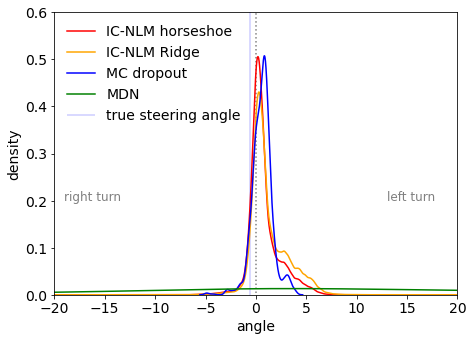

In [26]:
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(4,3))
plt.plot(np.linspace(min(density['axes']), max(density['axes']), 65536), densities_va_prec_horse_im[2], color = 'red', label = 'IC-NLM horseshoe')
plt.plot(np.linspace(min(density['axes']), max(density['axes']), 65536), densities_va_prec_im[2], color = 'orange', label = 'IC-NLM Ridge')
#plt.plot(np.linspace(min(density['axes']), max(density['axes']), 65536), densities_hmc_prec_horse[1], color = 'red', label = 'HMC Horseshoe')
#plt.plot(np.linspace(min(density['axes']), max(density['axes']), 65536), densities_hmc_prec[1], color = 'orange', label = 'HMC Ridge')
plt.plot(supports_im[2], densities_im[2], color = 'blue', label = 'MC dropout')
plt.plot(mdn_supports_im[2], mdn_densities_im[2], color = 'green', label = 'MDN')
plt.xlabel('angle')
plt.ylabel('density')
plt.xlim(-20,20)
plt.ylim(0,0.6)
plt.text(-19, 0.2, 'right turn', size=12, color='grey')
plt.text(13, 0.2, 'left turn', size=12, color='grey')
plt.vlines(x = 0, ymin = -1, ymax = 1, linestyle = 'dotted', color = 'grey')
plt.tight_layout()
plt.vlines(x = float(all_img_df[all_img_df['path'] == paths[0][35:]]['angle']), ymin = -1, ymax = 1, color = 'blue', label = 'true steering angle', alpha = 0.2)
plt.legend(framealpha=0.0)
fig.set_size_inches(8, 6)
figure = plt.gcf()
figure.set_size_inches(8, 6)
#plt.savefig('../../../data/commaai/calibration/examples_viz/dens_80_436run1.pdf') 

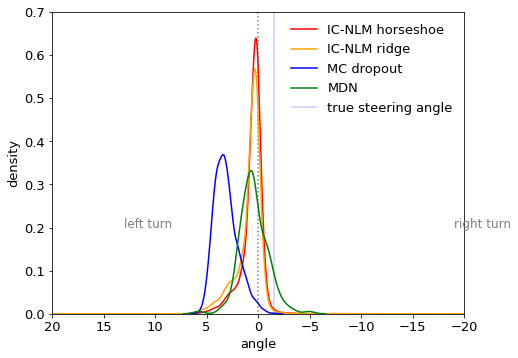

In [48]:
plt.rcParams.update({'font.size': 13})
fig = plt.figure(figsize=(4,3))
plt.plot(np.linspace(min(density['axes']), max(density['axes']), 65536), densities_va_prec_horse[1], color = 'red', label = 'IC-NLM horseshoe')
plt.plot(np.linspace(min(density['axes']), max(density['axes']), 65536), densities_va_prec[1], color = 'orange', label = 'IC-NLM ridge')
#plt.plot(np.linspace(min(density['axes']), max(density['axes']), 65536), densities_hmc_prec_horse[1], color = 'red', label = 'HMC Horseshoe')
#plt.plot(np.linspace(min(density['axes']), max(density['axes']), 65536), densities_hmc_prec[1], color = 'orange', label = 'HMC Ridge')
plt.plot(supports[1], densities[1], color = 'blue', label = 'MC dropout')
plt.plot(mdn_supports[1], mdn_densities[1], color = 'green', label = 'MDN')
plt.xlabel('angle')
plt.ylabel('density')
plt.xlim(-20,20)
plt.ylim(0,0.7)
plt.text(-19, 0.2, 'right turn', size=12, color='grey')
plt.text(13, 0.2, 'left turn', size=12, color='grey')
plt.vlines(x = 0, ymin = -1, ymax = 1, linestyle = 'dotted', color = 'grey')
plt.tight_layout()
plt.vlines(x = float(all_img_df[all_img_df['path'] == paths[1][35:]]['angle']), ymin = -1, ymax = 1, color = 'blue', label = 'true steering angle', alpha = 0.2)
plt.legend(framealpha=0.0)
plt.gca().invert_xaxis()
fig.set_size_inches(8, 6)
figure = plt.gcf()
figure.set_size_inches(8, 6)
plt.savefig('../../../data/commaai/calibration/examples_viz/dens_121_254run1.pdf', dpi = 100, bbox_inches='tight')

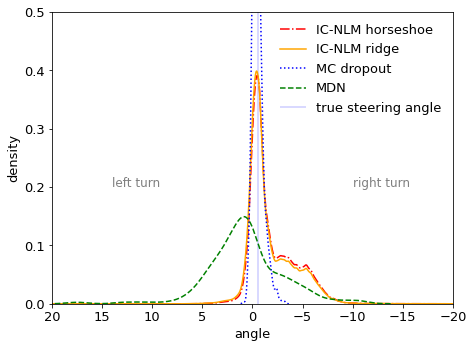

In [54]:
plt.rcParams.update({'font.size': 13})
fig = plt.figure(figsize=(4,3))
plt.vlines(x = float(all_img_df[all_img_df['path'] == paths[0][35:]]['angle']), ymin = -1, ymax = 1, color = 'blue', label = 'true steering angle', alpha = 0.2)
plt.plot(np.linspace(min(density['axes']), max(density['axes']), 65536), densities_va_prec_horse_im[0], color = 'red', label = 'IC-NLM horseshoe', linestyle = '-.')
plt.plot(np.linspace(min(density['axes']), max(density['axes']), 65536), densities_va_prec_im[0], color = 'orange', label = 'IC-NLM ridge')
#plt.plot(np.linspace(min(density['axes']), max(density['axes']), 65536), densities_hmc_prec_horse[0], color = 'red', label = 'HMC Horseshoe')
#plt.plot(np.linspace(min(density['axes']), max(density['axes']), 65536), densities_hmc_prec[0], color = 'orange', label = 'HMC Ridge', linestyle = '-.')
plt.plot(supports_im[0], densities_im[0], color = 'blue', label = 'MC dropout', linestyle = ':')
plt.plot(mdn_supports_im[0], mdn_densities_im[0], color = 'green', label = 'MDN', linestyle = '--')
plt.xlabel('angle')
plt.ylabel('density')
plt.xlim(-20,20)
plt.ylim(0,0.5)
plt.text(-10, 0.2, 'right turn', size=12, color='grey')
plt.text(14, 0.2, 'left turn', size=12, color='grey')
plt.tight_layout()
plt.legend(framealpha=0.0)
plt.gca().invert_xaxis()
fig.set_size_inches(8, 6)
figure = plt.gcf()
figure.set_size_inches(8, 6)
plt.savefig('dens_80_436run1.pdf', dpi = 100, bbox_inches='tight')
#plt.savefig('../../../data/commaai/calibration/examples_viz/dens_80_436run1.pdf', dpi = 100, bbox_inches='tight')

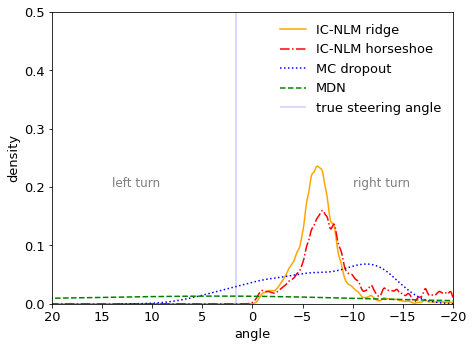

In [52]:
plt.rcParams.update({'font.size': 13})
fig = plt.figure(figsize=(4,3))
plt.vlines(x = float(review_df_test[review_df_test['path'] == paths[2][35:]]['angle']), ymin = -1, ymax = 1, color = 'blue', label = 'true steering angle', alpha = 0.2)
plt.plot(np.linspace(min(density['axes']), max(density['axes']), 65536), densities_va_prec[2], color = 'orange', label = 'IC-NLM ridge')
plt.plot(np.linspace(min(density['axes']), max(density['axes']), 65536), densities_va_prec_horse[2], color = 'red', label = 'IC-NLM horseshoe', linestyle = '-.')
#plt.plot(np.linspace(min(density['axes']), max(density['axes']), 65536), densities_hmc_prec_horse[2], color = 'red', label = 'HMC Horseshoe')
#plt.plot(np.linspace(min(density['axes']), max(density['axes']), 65536), densities_hmc_prec[2], color = 'orange', label = 'HMC Ridge', linestyle = '-.')
plt.plot(supports[2], densities[2], color = 'blue', label = 'MC dropout', linestyle = ':')
plt.plot(mdn_supports[2], mdn_densities[2], color = 'green', label = 'MDN', linestyle = '--')
plt.xlabel('angle')
plt.ylabel('density')
plt.xlim(-20,20)
plt.ylim(0,0.5)
plt.text(-10, 0.2, 'right turn', size=12, color='grey')
plt.text(14, 0.2, 'left turn', size=12, color='grey')
plt.tight_layout()
plt.legend(framealpha=0.0)
plt.gca().invert_xaxis()
fig.set_size_inches(8, 6)
figure = plt.gcf()
figure.set_size_inches(8, 6)
plt.savefig('dens_118_977run1.pdf', dpi = 100, bbox_inches='tight')
#plt.savefig('../../../data/commaai/calibration/examples_viz/dens_118_977run1.pdf', dpi = 100, bbox_inches='tight')

In [ ]:
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(4,3))
plt.plot(np.linspace(min(density['axes']), max(density['axes']), 65536), densities_va_prec_im[1], color = 'orange', label = 'IC-NLM ridge')
plt.plot(np.linspace(min(density['axes']), max(density['axes']), 65536), densities_va_prec_horse_im[1], color = 'red', label = 'IC-NLM horseshoe')
#plt.plot(np.linspace(min(density['axes']), max(density['axes']), 65536), densities_hmc_prec_horse[1], color = 'red', label = 'HMC Horseshoe')
#plt.plot(np.linspace(min(density['axes']), max(density['axes']), 65536), densities_hmc_prec[1], color = 'orange', label = 'HMC Ridge')
plt.plot(supports_im[1], densities_im[1], color = 'blue', label = 'MC dropout')
plt.plot(mdn_supports_im[1], mdn_densities_im[1], color = 'green', label = 'MDN')
plt.xlabel('angle')
plt.ylabel('density')
plt.xlim(-20,20)
plt.ylim(0,0.6)
plt.text(-10, 0.2, 'right turn', size=12, color='grey')
plt.text(14, 0.2, 'left turn', size=12, color='grey')
plt.vlines(x = 0, ymin = -1, ymax = 1, linestyle = 'dotted', color = 'grey')
plt.tight_layout()
plt.vlines(x = float(review_df_test[review_df_test['path'] == paths[1][35:]]['angle']), ymin = -1, ymax = 1, color = 'blue', label = 'true steering angle', alpha = 0.2)
plt.legend(framealpha=0.0)
plt.gca().invert_xaxis()
plt.savefig('dens_118_977run1_im.pdf') 
#plt.savefig('../../../data/commaai/calibration/examples_viz/dens_118_977run1_im.pdf') 

In [ ]:
plt.plot(np.linspace(min(density['axes']), max(density['axes']), 65536), densities_va_prec_im[2], color = 'orange', label = 'ICDNLM Ridge')
plt.plot(np.linspace(min(density['axes']), max(density['axes']), 65536), densities_va_prec_horse_im[2], color = 'red', label = 'ICDNLM Horseshoe')
#plt.plot(np.linspace(min(density['axes']), max(density['axes']), 65536), densities_hmc_prec_horse[1], color = 'red', label = 'HMC Horseshoe')
#plt.plot(np.linspace(min(density['axes']), max(density['axes']), 65536), densities_hmc_prec[1], color = 'orange', label = 'HMC Ridge')
plt.plot(supports_im[2], densities_im[2], color = 'blue', label = 'MC-Dropout')
plt.plot(mdn_supports_im[2], mdn_densities_im[2], color = 'green', label = 'MDN')
plt.xlabel('angle')
plt.ylabel('density')
plt.xlim(-20,20)
plt.ylim(0,0.6)
plt.text(-10, 0.2, 'right turn', size=12, color='grey')
plt.text(14, 0.2, 'left turn', size=12, color='grey')
plt.vlines(x = 0, ymin = -1, ymax = 1, linestyle = 'dotted', color = 'grey')
plt.tight_layout()
plt.vlines(x = float(review_df_test[review_df_test['path'] == paths[2][35:]]['angle']), ymin = -1, ymax = 1, color = 'blue', label = 'true steering angle', alpha = 0.2)
plt.legend(framealpha=0.0)
plt.gca().invert_xaxis()
plt.savefig('../../../data/commaai/calibration/examples_viz/dens_118_977run1_im.pdf') 

## 4. Plot images

In [ ]:
def change_brightness(img, value=30):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    v = cv2.add(v,value)
    v[v > 255] = 255
    v[v < 0] = 0
    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img

In [ ]:
img = imageio.imread(paths[0])
#img = cv2.resize(img, dsize = (291,218), interpolation = cv2.INTER_LINEAR)[76:142, 45:245,0:3]/255
figure, ax = plt.figure(), plt.gca()
ax.imshow(change_brightness(img[:,:,0:3]))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.tight_layout()
#figure.savefig('../../../data/commaai/calibration/examples_viz/80_436run1.pdf', format='pdf', dpi=900)

In [ ]:
#img = imageio.imread(paths[1])
img = imageio.imread('../../../data/commaai/train_bags_2/0/75_436run1.png')
#img = cv2.resize(img, dsize = (291,218), interpolation = cv2.INTER_LINEAR)[76:142, 45:245,0:3]/255
figure, ax = plt.figure(), plt.gca()
ax.imshow(img[:,:,0:3])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.tight_layout()
#figure.savefig('../../../data/commaai/calibration/examples_viz/121_254run1.pdf', format='pdf', dpi=900)

In [ ]:
img = change_brightness(imageio.imread(paths[2]), value = 70)
#img = cv2.resize(img, dsize = (291,218), interpolation = cv2.INTER_LINEAR)[76:142, 45:245,0:3]/255
figure, ax = plt.figure(), plt.gca()
ax.imshow(img[:,:,0:3])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.tight_layout()
#figure.savefig('../../../data/commaai/calibration/examples_viz/118_977run1.pdf', format='pdf', dpi=900)

In [ ]:
img = imageio.imread('../../../data/old/train_bags_2/0/1_436run1.png')

In [ ]:
figure, ax = plt.figure(), plt.gca()
ax.imshow(change_brightness(img[:,:,0:3], value = 70))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.tight_layout()
ax.axis("off")
figure.savefig('../../../data/commaai/calibration/examples_viz/example_1.pdf', format='pdf', dpi=900)

In [ ]:
img = imageio.imread('../../../data/old/train_bags_2/0/10_555run1.png')
figure, ax = plt.figure(), plt.gca()
ax.imshow(change_brightness(img[:,:,0:3], value = 70))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.tight_layout()
ax.axis("off")
figure.savefig('../../../data/commaai/calibration/examples_viz/example_2.pdf', format='pdf', dpi=900)